<a href="https://colab.research.google.com/github/santule/ERA/blob/main/s7/Session_7_Model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolution block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3), # 16,26,26
            nn.ReLU(),
            nn.Conv2d(16, 32, 3), # 32,24,24
            nn.ReLU(),
        )
        # transition block 1
        self.trans_block1 = nn.Sequential(
            nn.MaxPool2d(2, 2), # 32,12,12 - reduce output
            nn.Conv2d(32, 16, 1), # 16,12,12 - reduce channels
            nn.ReLU()
        )
        # convolution block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3), # 32,10,10
            nn.ReLU(),
            nn.Conv2d(32, 64, 3), # 64,8,8
            nn.ReLU(),
        )

        # transition block 2
        self.trans_block2 = nn.Sequential(
            nn.MaxPool2d(2, 2), # 64,4,4 - reduce output
            nn.Conv2d(64, 32, 1), # 32,4,4 - reduce channels
            nn.ReLU()
        )

        # final block
        self.final_block = nn.Sequential(
            nn.Conv2d(32, 10, 1), # 10,4,4
            nn.ReLU(),
            nn.Conv2d(10, 10, 4)  # 10
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans_block1(x)
        x = self.conv2(x)
        x = self.trans_block2(x)
        x = self.final_block(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)

In [16]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,640
              ReLU-4           [-1, 32, 24, 24]               0
         MaxPool2d-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 16, 12, 12]             528
              ReLU-7           [-1, 16, 12, 12]               0
            Conv2d-8           [-1, 32, 10, 10]           4,640
              ReLU-9           [-1, 32, 10, 10]               0
           Conv2d-10             [-1, 64, 8, 8]          18,496
             ReLU-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
           Conv2d-13             [-1, 32, 4, 4]           2,080
             ReLU-14             [-1, 3

In [20]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [21]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=2.0838491916656494 Batch_id=468 Accuracy=12.04: 100%|██████████| 469/469 [00:16<00:00, 27.60it/s]



Test set: Average loss: 2.0523, Accuracy: 4880/10000 (48.80%)

EPOCH: 1


Loss=0.22020524740219116 Batch_id=468 Accuracy=90.46: 100%|██████████| 469/469 [00:17<00:00, 27.28it/s]



Test set: Average loss: 0.1148, Accuracy: 9649/10000 (96.49%)

EPOCH: 2


Loss=0.04091125354170799 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:17<00:00, 26.69it/s]



Test set: Average loss: 0.0744, Accuracy: 9779/10000 (97.79%)

EPOCH: 3


Loss=0.07958044856786728 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s]



Test set: Average loss: 0.0549, Accuracy: 9813/10000 (98.13%)

EPOCH: 4


Loss=0.09612206369638443 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]



Test set: Average loss: 0.0589, Accuracy: 9800/10000 (98.00%)

EPOCH: 5


Loss=0.01089500356465578 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]



Test set: Average loss: 0.0455, Accuracy: 9846/10000 (98.46%)

EPOCH: 6


Loss=0.012107004411518574 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]



Test set: Average loss: 0.0462, Accuracy: 9852/10000 (98.52%)

EPOCH: 7


Loss=0.0336330309510231 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]



Test set: Average loss: 0.0405, Accuracy: 9861/10000 (98.61%)

EPOCH: 8


Loss=0.044683780521154404 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:17<00:00, 26.74it/s]



Test set: Average loss: 0.0376, Accuracy: 9871/10000 (98.71%)

EPOCH: 9


Loss=0.018387863412499428 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]



Test set: Average loss: 0.0374, Accuracy: 9867/10000 (98.67%)

EPOCH: 10


Loss=0.07998151332139969 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:17<00:00, 26.36it/s]



Test set: Average loss: 0.0364, Accuracy: 9880/10000 (98.80%)

EPOCH: 11


Loss=0.0050222668796777725 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]



Test set: Average loss: 0.0315, Accuracy: 9889/10000 (98.89%)

EPOCH: 12


Loss=0.0245391596108675 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]



Test set: Average loss: 0.0318, Accuracy: 9881/10000 (98.81%)

EPOCH: 13


Loss=0.03073972277343273 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 26.65it/s]



Test set: Average loss: 0.0325, Accuracy: 9883/10000 (98.83%)

EPOCH: 14


Loss=0.024533336982131004 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]



Test set: Average loss: 0.0341, Accuracy: 9869/10000 (98.69%)



Text(0.5, 1.0, 'Test Accuracy')

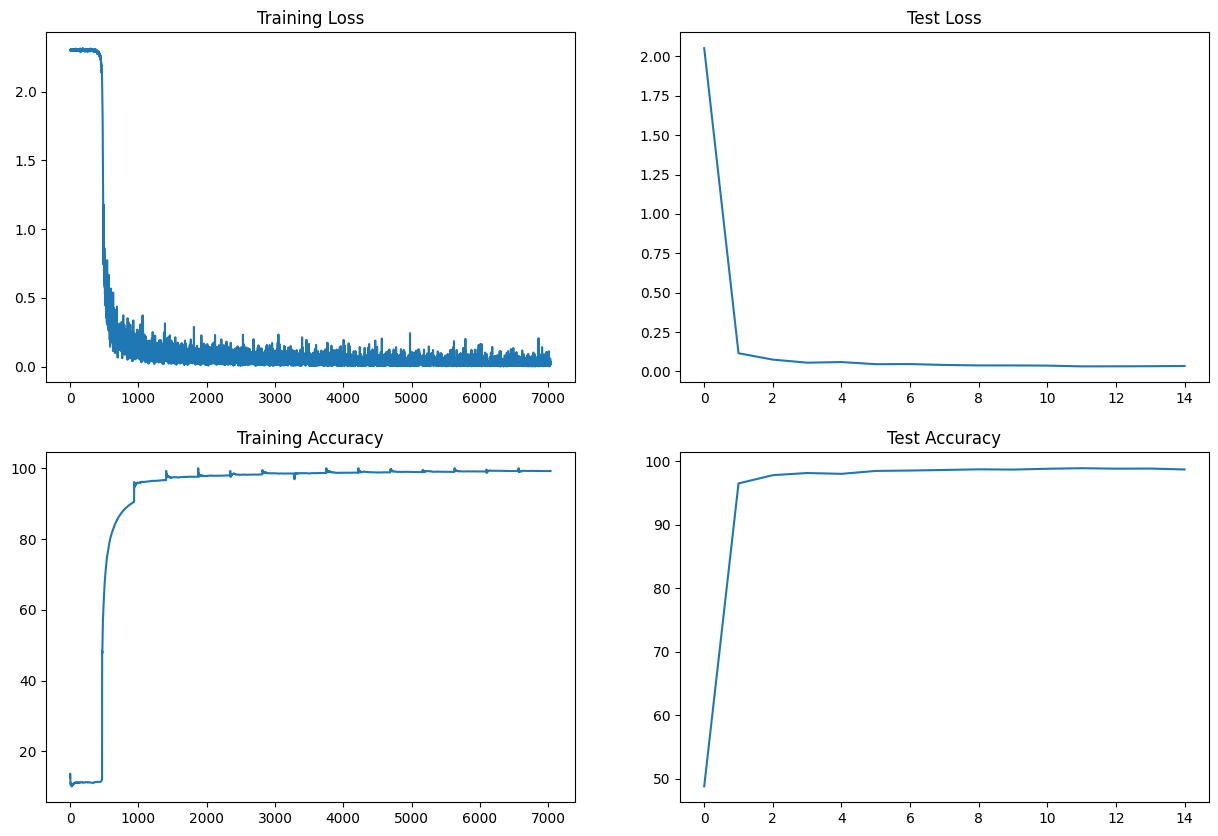

In [22]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")